# OpenAI-to-Z Challenge: Refined Hough Transform Analysis

This notebook implements the advanced preprocessing and analysis pipeline based on expert feedback. The goal is to correctly identify potential archaeological earthworks by filtering out data artifacts and enhancing subtle terrain features.

**Pipeline:**
1.  Load the DTM raster and mask `NoData` values.
2.  Generate a hillshade from the DTM to accentuate terrain.
3.  Apply a high-pass filter to the hillshade to enhance low-relief features.
4.  Use the Canny edge detector on the filtered image.
5.  Apply a constrained Probabilistic Hough Line Transform to find lines of archaeological interest (30-400m).
6.  Visualize the results and save the output.

## 1. Setup and Imports

In [1]:
import os
import rasterio
import numpy as np
import cv2
import matplotlib.pyplot as plt

print("Libraries imported.")

Libraries imported.


## 2. Load DTM and Apply NoData Mask

In [2]:
dtm_raster_path = '/Users/shg/Projects/openai-a-z-challenge/data/raw/TAL_A01_2018/TAL_A01_2018_DTM/TAL01L0001C0002.grd'

try:
    with rasterio.open(dtm_raster_path) as src:
        dtm_data = src.read(1, masked=True) # Read the first band as a masked array
        profile = src.profile
        print(f"DTM file loaded successfully. Shape: {dtm_data.shape}")
except Exception as e:
    print(f"Error loading DTM file: {e}")

DTM file loaded successfully. Shape: (1001, 1001)


## 3. Generate and Filter Hillshade

First, we create a hillshade from the DTM. Then, we apply a high-pass filter to remove large-scale topographic trends and emphasize small, linear features.

In [3]:
def simple_hillshade(array, azimuth, altitude):
    """Calculates a simple hillshade from a DTM array using numpy."""
    x, y = np.gradient(array)
    slope = np.pi/2. - np.arctan(np.sqrt(x*x + y*y))
    aspect = np.arctan2(-x, y)
    azimuthrad = azimuth*np.pi/180.
    altituderad = altitude*np.pi/180.
    
    shaded = np.sin(altituderad) * np.sin(slope) + np.cos(altituderad) * np.cos(slope) * np.cos((azimuthrad - np.pi/2.) - aspect)
    
    return 255*(shaded + 1)/2

def high_pass_filter(image, kernel_size=21):
    """Applies a high-pass filter by subtracting a blurred version of the image."""
    # Create a blurred version of the image
    blurred = cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)
    # Subtract the blurred image from the original
    filtered = cv2.subtract(image, blurred)
    return filtered

try:
    # Generate hillshade from the DTM data
    hillshade_data = simple_hillshade(dtm_data, 315, 45)
    
    # Apply the high-pass filter
    filtered_hillshade = high_pass_filter(hillshade_data)
    print("Hillshade generated and high-pass filter applied.")
except NameError:
    print("DTM data not loaded, skipping hillshade generation.")

Hillshade generated and high-pass filter applied.


## 4. Detect Lines with Constrained Hough Transform

In [4]:
def detect_lines_refined(image_data, resolution_m=1.0):
    """Detects lines using Canny and a constrained Hough Transform."""
    # Normalize the image for Canny detector
    normalized_image = cv2.normalize(image_data, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    
    # Apply Canny edge detection
    edges = cv2.Canny(normalized_image, 50, 150, apertureSize=3)
    
    # Constrain line length based on real-world measurements
    min_line_length_pixels = int(30 / resolution_m)
    max_line_gap_pixels = int(15 / resolution_m)
    
    # Apply Probabilistic Hough Line Transform
    lines = cv2.HoughLinesP(
        edges, 
        1, 
        np.pi / 180, 
        threshold=50, 
        minLineLength=min_line_length_pixels, 
        maxLineGap=max_line_gap_pixels
    )
    
    return lines, edges

try:
    # Assuming 1-meter resolution for the DTM
    pixel_resolution = profile['transform'][0]
    detected_lines, detected_edges = detect_lines_refined(filtered_hillshade, resolution_m=pixel_resolution)
    
    if detected_lines is not None:
        print(f"Found {len(detected_lines)} potential linear features.")
    else:
        print("No linear features were detected.")
except NameError:
    print("Hillshade data not available, skipping line detection.")

Found 2322 potential linear features.


## 5. Visualize the Refined Results

Visualization saved to /Users/shg/Projects/openai-a-z-challenge/hough_transform_results_refined.png


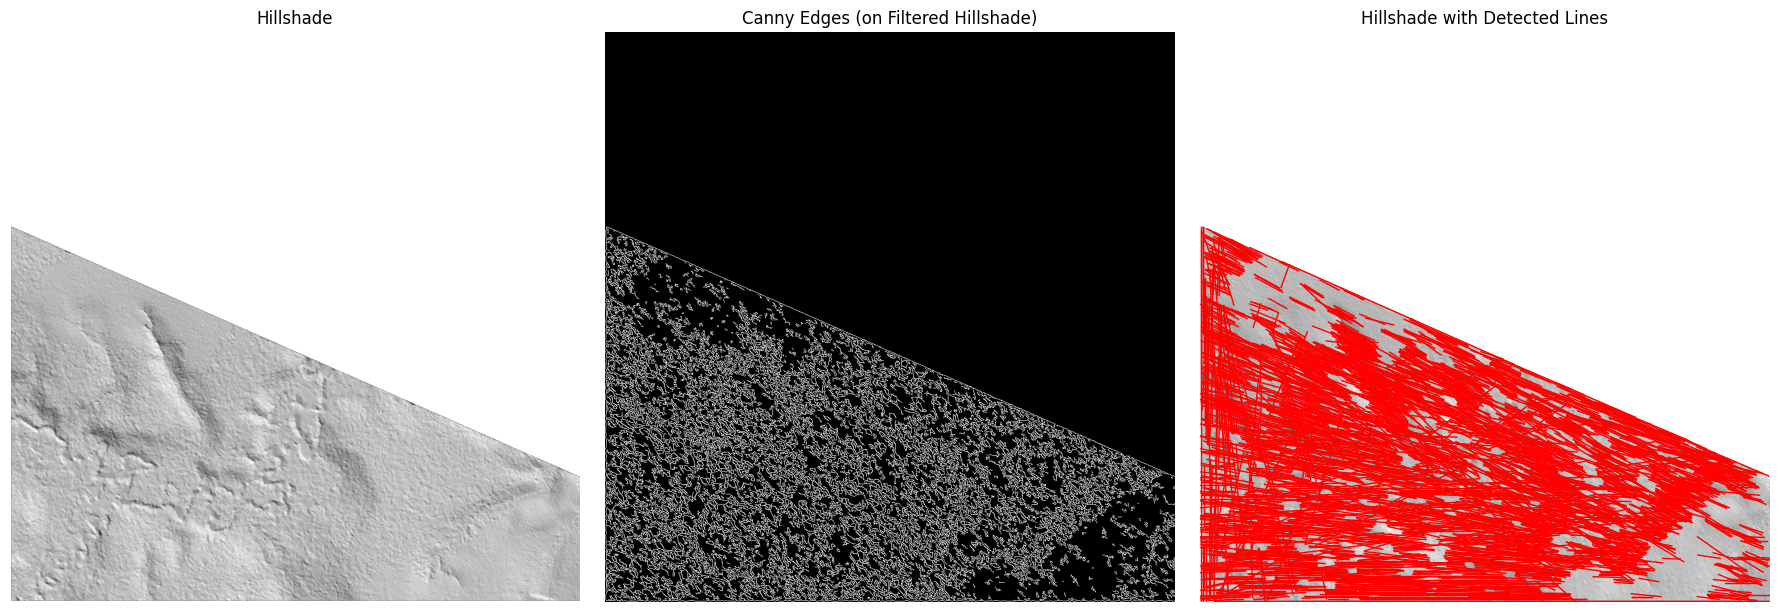

In [5]:
try:
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # 1. Hillshade
    axes[0].imshow(hillshade_data, cmap='gray')
    axes[0].set_title('Hillshade')
    axes[0].axis('off')

    # 2. Canny Edges on Filtered Hillshade
    axes[1].imshow(detected_edges, cmap='gray')
    axes[1].set_title('Canny Edges (on Filtered Hillshade)')
    axes[1].axis('off')

    # 3. Hillshade with Detected Lines
    axes[2].imshow(hillshade_data, cmap='gray')
    if detected_lines is not None:
        for line in detected_lines:
            x1, y1, x2, y2 = line[0]
            axes[2].plot([x1, x2], [y1, y2], 'r-', linewidth=1)
    axes[2].set_title('Hillshade with Detected Lines')
    axes[2].axis('off')

    plt.tight_layout()
    
    # Save the figure
    output_path = '/Users/shg/Projects/openai-a-z-challenge/hough_transform_results_refined.png'
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    print(f"Visualization saved to {output_path}")
    
    plt.show()
except NameError:
    print("Could not generate visualization because data was not processed correctly.")